In [1607]:
import numpy as np
from openqaoa.problems import BinPacking, MaximumCut, TSP, ShortestPath
from openqaoa.utilities import plot_graph
import json
import pprint
import networkx as nx
import matplotlib.pyplot as plt

In [1608]:
desiredProblemType = 'TSP' #options: 'BinPacking', 'MaxCut', 'TSP', 'ShortestPath'

In [ ]:
if desiredProblemType == 'BinPacking': #doesnt seem possible to get a non-trivial example of this problem in less than 12 qubits
    n_items = 2 # number of items
    n_bins = 2 # maximum number of bins the solution will be explored on
    min_weight = 1 # minimum weight of the items
    max_weight = 3 # maximum weight of the items
    weight_capacity = 5 # weight capacity of the bins
    weights = np.random.default_rng(seed=1234).integers(low=min_weight, high=max_weight, size=n_items) # random instance of the problem

    bpp = BinPacking(weights, weight_capacity, n_bins=n_bins, simplifications=False) #it is here that you would specifiy the penalty for the bin packing problem
    quboProb = bpp.qubo

elif desiredProblemType == 'MaxCut':
    G = nx.generators.fast_gnp_random_graph(n=9, p=0.6) #you can fix the seed for the graphs here
    maxcut_prob = MaximumCut(G)
    quboProb = maxcut_prob.qubo

elif desiredProblemType == 'TSP':
    n_cities = 4  # Number of cities for TSP
    connection_probability = 1  # Probability for edge creation in gnp_random_graph
    # Ensure the graph is connected
    G = nx.generators.fast_gnp_random_graph(n=n_cities, p=connection_probability) 

    min_edge_weight = 1
    max_edge_weight = 10 
    rng_weights = np.random.default_rng() # Use a different seed or manage seeds as needed
    for (u, v) in G.edges():
        weight = int(rng_weights.integers(low=min_edge_weight, high=max_edge_weight, endpoint=True)) # endpoint=True includes high value
        G.edges[u, v]['weight'] = weight
    # A is the penalty for not visiting a city or visiting it multiple times.
    # B is the penalty for not having a valid tour structure (e.g. sub-tours or incorrect number of cities at a position)
    B_val = 1
    A_val = 9
    tsp_prob = TSP(G=G, A=A_val, B=B_val) # Using your specified A and B penalties
    quboProb = tsp_prob.qubo
 

elif desiredProblemType == 'ShortestPath': #not sure that the exact solver is working right for this one
    G = nx.generators.fast_gnp_random_graph(n=6, p=0.6)
    nx.set_edge_attributes(G, values = 1, name = 'weight')
    nx.set_node_attributes(G, values = 1, name = 'weight')
    sp_prob = ShortestPath(G, source=0, dest=5)
    quboProb = sp_prob.qubo

quboProb.hamiltonian.expression

-33.75Z_{1} - 33.75Z_{21} - 34.25Z_{23} - 34.25Z_{3} - 34.75Z_{24} - 34.75Z_{4} - 36.0Z_{0} - 36.0Z_{20} - 36.5Z_{11} - 36.5Z_{16} - 36.5Z_{6} - 38.25Z_{22} - 38.25Z_{2} - 38.5Z_{13} - 38.5Z_{18} - 38.5Z_{8} - 39.0Z_{10} - 39.0Z_{15} - 39.0Z_{5} - 40.5Z_{14} - 40.5Z_{19} - 40.5Z_{9} - 43.5Z_{12} - 43.5Z_{17} - 43.5Z_{7} + 0.5Z_{0}Z_{6} + 0.5Z_{10}Z_{16} + 0.5Z_{11}Z_{15} + 0.5Z_{15}Z_{21} + 0.5Z_{16}Z_{20} + 0.5Z_{1}Z_{5} + 0.5Z_{5}Z_{11} + 0.5Z_{6}Z_{10} + 0.75Z_{11}Z_{19} + 0.75Z_{14}Z_{16} + 0.75Z_{16}Z_{24} + 0.75Z_{19}Z_{21} + 0.75Z_{1}Z_{9} + 0.75Z_{4}Z_{6} + 0.75Z_{6}Z_{14} + 0.75Z_{9}Z_{11} + 1.0Z_{0}Z_{8} + 1.0Z_{10}Z_{18} + 1.0Z_{13}Z_{15} + 1.0Z_{15}Z_{23} + 1.0Z_{18}Z_{20} + 1.0Z_{3}Z_{5} + 1.0Z_{5}Z_{13} + 1.0Z_{8}Z_{10} + 1.5Z_{11}Z_{18} + 1.5Z_{13}Z_{16} + 1.5Z_{13}Z_{19} + 1.5Z_{14}Z_{18} + 1.5Z_{16}Z_{23} + 1.5Z_{18}Z_{21} + 1.5Z_{18}Z_{24} + 1.5Z_{19}Z_{23} + 1.5Z_{1}Z_{8} + 1.5Z_{3}Z_{6} + 1.5Z_{3}Z_{9} + 1.5Z_{4}Z_{8} + 1.5Z_{6}Z_{13} + 1.5Z_{8}Z_{11} + 1.5Z_{8}Z_{1

In [1610]:
qubo_dict = quboProb.asdict()
data_to_save = {
    "terms": qubo_dict["terms"],
    "weights": qubo_dict["weights"],
    "constant": qubo_dict.get("constant", 0.0),
    "problem_type": qubo_dict.get("problem_instance", {}).get("problem_type", "unknown")
}

file_path = "qubo_data.json"
with open(file_path, "w") as f:
    json.dump(data_to_save, f)

print(f"QUBO data saved to {file_path}")
print("Saved data structure example:")
#print(json.dumps(data_to_save, indent=2))
print(quboProb.asdict()) # Original full dictionary from OpenQAOA

QUBO data saved to qubo_data.json
Saved data structure example:
{'terms': [[0, 5], [1, 6], [2, 7], [8, 3], [9, 4], [0, 10], [1, 11], [2, 12], [3, 13], [4, 14], [0, 15], [16, 1], [17, 2], [18, 3], [19, 4], [0, 20], [1, 21], [2, 22], [3, 23], [24, 4], [10, 5], [11, 6], [12, 7], [8, 13], [9, 14], [5, 15], [16, 6], [17, 7], [8, 18], [9, 19], [20, 5], [21, 6], [22, 7], [8, 23], [24, 9], [10, 15], [16, 11], [17, 12], [18, 13], [19, 14], [10, 20], [11, 21], [12, 22], [13, 23], [24, 14], [20, 15], [16, 21], [17, 22], [18, 23], [24, 19], [0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4], [5, 6], [5, 7], [8, 5], [9, 5], [6, 7], [8, 6], [9, 6], [8, 7], [9, 7], [8, 9], [10, 11], [10, 12], [10, 13], [10, 14], [11, 12], [11, 13], [11, 14], [12, 13], [12, 14], [13, 14], [16, 15], [17, 15], [18, 15], [19, 15], [16, 17], [16, 18], [16, 19], [17, 18], [17, 19], [18, 19], [20, 21], [20, 22], [20, 23], [24, 20], [21, 22], [21, 23], [24, 21], [22, 23], [24, 22], [24, 23], [0, 6

In [1611]:
#exact solver for later comparison to qunatum results
hamiltonian = quboProb.hamiltonian
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 24.0, Solution: ['0000101000100000001000100', '0010000010100000100000001']


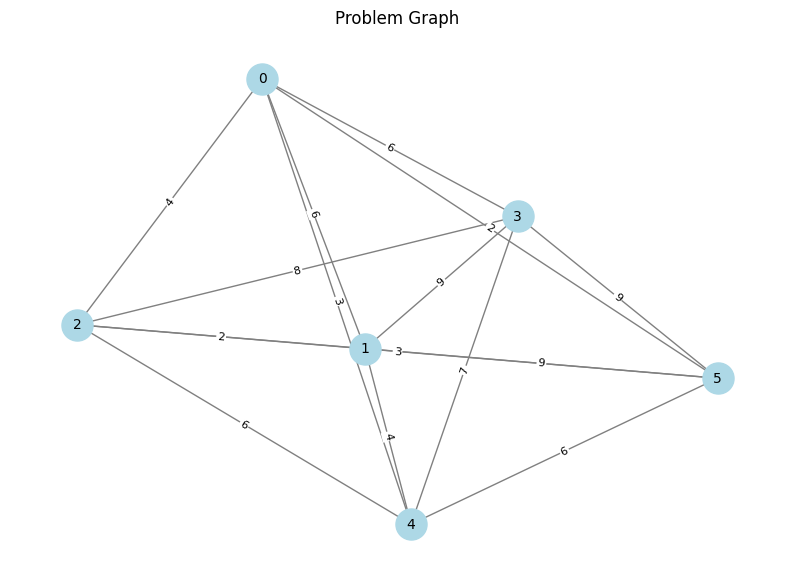

In [1612]:
pos = nx.kamada_kawai_layout(G)
pos = nx.random_layout(G, seed=0)
pos = nx.spring_layout(G, seed=0)
fig, ax = plt.subplots(figsize=(10, 7)) # You can adjust figsize as needed
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="grey", width=1.0)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)

edge_weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_weights,
    ax=ax,
    font_color='black', # Color of the weight text
    font_size=8,
    bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=1) # Optional: add a small white background to edge labels for readability
)
ax.set_title("Problem Graph")
plt.axis('off')
plt.show()

In [1613]:
quboProb.asdict()

{'terms': [[0, 5],
  [1, 6],
  [2, 7],
  [8, 3],
  [9, 4],
  [0, 10],
  [1, 11],
  [2, 12],
  [3, 13],
  [4, 14],
  [0, 15],
  [16, 1],
  [17, 2],
  [18, 3],
  [19, 4],
  [0, 20],
  [1, 21],
  [2, 22],
  [3, 23],
  [24, 4],
  [10, 5],
  [11, 6],
  [12, 7],
  [8, 13],
  [9, 14],
  [5, 15],
  [16, 6],
  [17, 7],
  [8, 18],
  [9, 19],
  [20, 5],
  [21, 6],
  [22, 7],
  [8, 23],
  [24, 9],
  [10, 15],
  [16, 11],
  [17, 12],
  [18, 13],
  [19, 14],
  [10, 20],
  [11, 21],
  [12, 22],
  [13, 23],
  [24, 14],
  [20, 15],
  [16, 21],
  [17, 22],
  [18, 23],
  [24, 19],
  [0, 1],
  [0, 2],
  [0, 3],
  [0, 4],
  [1, 2],
  [1, 3],
  [1, 4],
  [2, 3],
  [2, 4],
  [3, 4],
  [5, 6],
  [5, 7],
  [8, 5],
  [9, 5],
  [6, 7],
  [8, 6],
  [9, 6],
  [8, 7],
  [9, 7],
  [8, 9],
  [10, 11],
  [10, 12],
  [10, 13],
  [10, 14],
  [11, 12],
  [11, 13],
  [11, 14],
  [12, 13],
  [12, 14],
  [13, 14],
  [16, 15],
  [17, 15],
  [18, 15],
  [19, 15],
  [16, 17],
  [16, 18],
  [16, 19],
  [17, 18],
  [17, 19],
  [